## Quick assessment for domeflat construction
### Py3

In [1]:
import os
import sys
import time
import datetime
import numpy as np
import easyaccess as ea
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DayLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from descolors import BAND_COLORS
%matplotlib inline
# %matplotlib notebook
# import mpld3
# mpld3.enable_notebook()

### Setup easyaccess connection

In [2]:
connect = ea.connect('desoper')
cursor = connect.cursor()

Connecting to DB ** desoper ** ...


##### For each night, need to discard the first domeflat, because it can inherit some electronic noise

In [3]:
# remember other way to join is using MISCFILE table
nights = [20170815, 20170902]
reqnum = 3366
attnum = 1
t0 = time.time()
q1  = 'select e.nite, qa.expnum, e.band, e.exptime, qa.factor, qa.rms, qa.worst,'
q1 += ' att.id, qa.filename'
q1 += ' from flat_qa qa, exposure e, pfw_attempt att, desfile d'
q1 += ' where e.nite between {0} and {1}'.format(*nights)
q1 += ' and qa.expnum=e.expnum'
q1 += ' and qa.filename=d.filename'
q1 += ' and d.pfw_attempt_id=att.id'
q1 += ' and att.data_state=\'NEW\''
q1 += ' and att.reqnum={0}'.format(reqnum)
q1 += ' and att.attnum={0}'.format(attnum)
q1 += ' order by qa.expnum'
df1 = connect.query_to_pandas(q1)
t1 = time.time()

# For each night, need to discard the first domeflat, because it can inherit some electronic noise
n_aux = np.unique(df1['NITE'].values)
idx2drop = []
for n in n_aux:
    min_idx_exp = df1.loc[df1['NITE'] == n, 'EXPNUM'].idxmin()
    # df1['EXPNUM'].iloc[min_idx_exp]
    idx2drop.append(min_idx_exp)
# Drop the selected indices, using the index() object
df1.drop(df1.index[idx2drop], inplace=True)
df1.reset_index(drop=True, inplace=True)

if True:
    df1.to_csv('dflat_pid{0}.csv'.format(os.getpid()), index=False, header=True)

### Check exposure times are the same per band

In [27]:
for bx in df1['BAND'].unique():
    n_exptime = df1.loc[df1['BAND'] == bx, 'EXPTIME'].unique().size
    if (n_exptime != 1):
        print('ERROR: Band {0} has multiple ({1}) exposure times!'.format(bx, n_exptime))
    else:
        pass

In [ ]:
# df1 = pd.read_csv('dflat_pid1382.csv')

In [ ]:
# If want to load the table... but keep in mind the table has not dropped the first domeflat of the night
if False:
    df2 = pd.read_csv('FLAT_QA_20170815t0902.csv')
    # Check if both are the same
    print(df1['EXPNUM'].equals(df2['EXPNUM']))

### Plot per band, excluding VR

In [4]:
aux_b = df1.loc[df1['BAND'] != 'VR', 'BAND'].unique()

### From flat_qa: factor, rms and worst

In [5]:
def to_datetime(arr_nite):
    dateFmt = DateFormatter('%b/%d/%y')
    xdate = [datetime.datetime.strptime(str(date), '%Y%m%d')
             for date in np.sort(arr_nite)]
    return xdate

In [6]:
def plot_FLATQA(dframe, b):
    # Get subset
    dx = dframe.loc[df1['BAND'] == b]
    # Setup datetime auxiliaries
    aux_time = to_datetime(dx['NITE'].values)
    months = MonthLocator()
    two_days = DayLocator(interval=2)
    days = DayLocator()
    dateFmt = DateFormatter('%b/%d/%y')
    # Plotting
    plt.close('all')
    fig, ax = plt.subplots(3, 1, figsize=(12,8))
    # for idx, row in dx.iterrows():
    #     ax[0].plot(aux_time, row['FACTOR'], marker='s', color=BAND_COLORS[b])
    #     ax[1].plot(aux_time, row['RMS'], marker='o', color=BAND_COLORS[b])
    #     ax[2].plot(aux_time, row['WORST'], marker='^', color=BAND_COLORS[b])
    ax[0].scatter(aux_time, dx['FACTOR'], marker='o', color=BAND_COLORS[b])
    ax[1].scatter(aux_time, dx['RMS'], marker='D', color=BAND_COLORS[b])
    ax[2].scatter(aux_time, dx['WORST'], marker='^', color=BAND_COLORS[b])
    # Labels
    ax[0].set_title('{0}-band'.format(b), fontsize=12)
    ax[0].set_ylabel('factor')
    ax[1].set_ylabel('rms')
    ax[2].set_ylabel('worst')
    ax[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax[2].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    # Axis locators
    ax[-1].xaxis.set_major_locator(two_days)
    ax[-1].xaxis.set_major_formatter(dateFmt)
    ax[-1].xaxis.set_minor_locator(days)
    ax[-1].autoscale_view()
    for xx in ax:
        xx.set_xlim([aux_time[0] - datetime.timedelta(days=1), 
                     aux_time[-1] + datetime.timedelta(days=1)])
    # Remove upper plots ticks labels
    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.setp(ax[1].get_xticklabels(), visible=False)
    ax[2].tick_params(rotation=30)
    # Other way:
    # xlabels_ax1 = ax[-1].get_xticklabels()
    # plt.setp(xlabels_ax1, rotation=30, fontsize=10)
    plt.subplots_adjust(hspace=0.025)

### Band: u

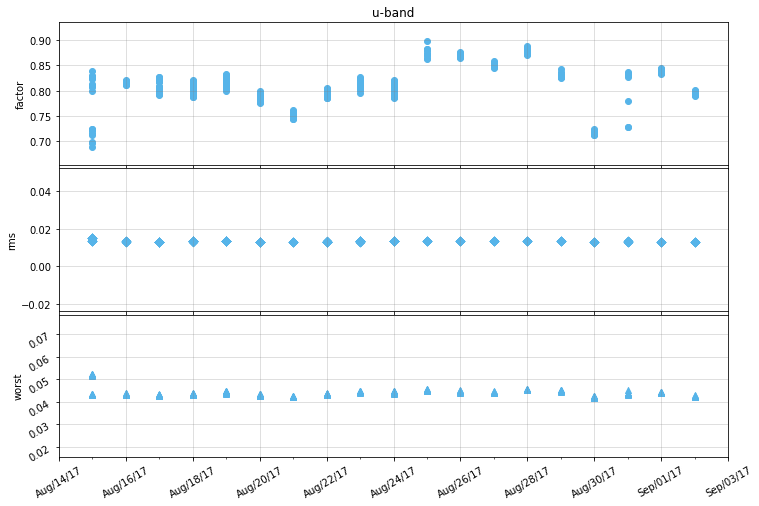

In [7]:
plot_FLATQA(df1, 'u')

#### Selection

In [8]:
# Select those having a factor > 0.75 and keep that EXPNUM list to check against DWT
s_u = df1.copy(deep=True)
s_u = s_u.loc[(s_u['BAND'] == 'u') & (s_u['NITE'].astype('int64') <= 20170824)]
print(len(s_u.index))
s_u = s_u.loc[(s_u['FACTOR'] >= 0.75) & (s_u['WORST'] <= 0.05)]
print(len(s_u.index))
# Double checking uniqueness
print(np.unique(s_u['EXPNUM'].values).size)

178
154
154


In [16]:
# Some quick metrics
aux_var_u = (s_u['FACTOR'].max() - s_u['FACTOR'].min()) * 100. / np.median(s_u['FACTOR'])
print('Variability in percetage of the median = {0:.2f}%\nMedian={1:.2f}'.format(aux_var_u, np.median(s_u['FACTOR'])))

Variability in percetage of the median = 10.25%
Median=0.80


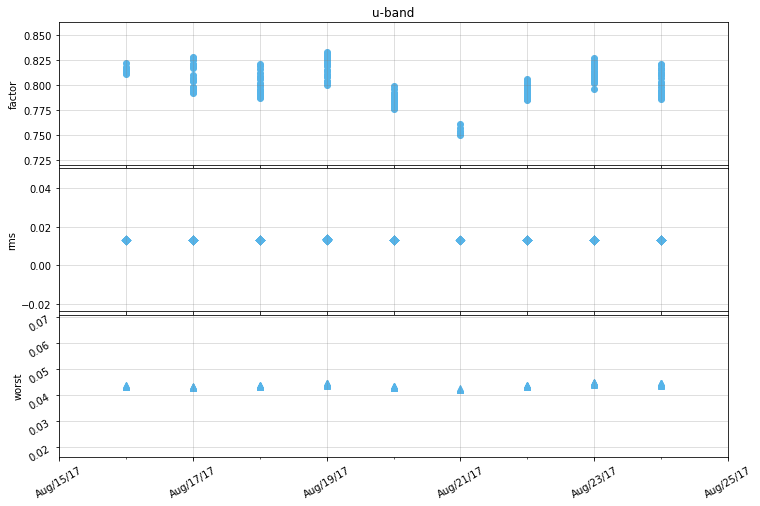

In [17]:
plot_FLATQA(s_u, 'u')

### Band: g

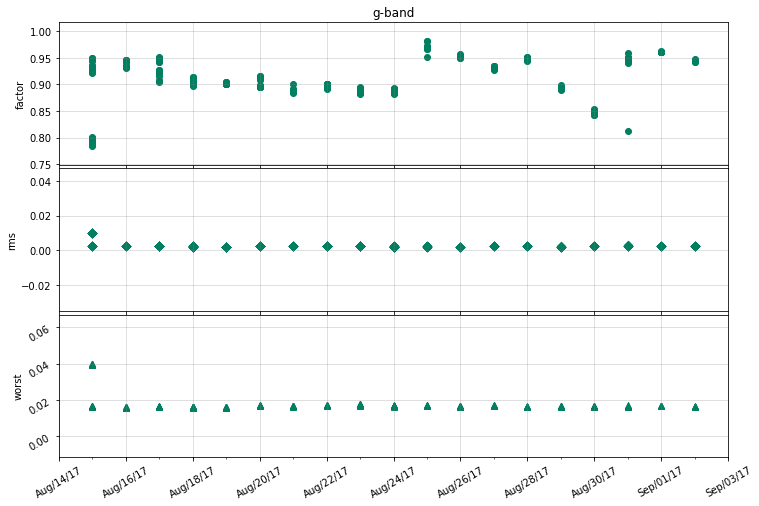

In [18]:
plot_FLATQA(df1, 'g')

#### Selection

In [19]:
# Select those having a factor > 0.75 and keep that EXPNUM list to check against DWT
s_g = df1.copy(deep=True)
s_g = s_g.loc[(s_g['BAND'] == 'g') & (s_g['NITE'].astype('int64') <= 20170824)]
print(len(s_g.index))
s_g = s_g.loc[(s_g['FACTOR'] >= 0.85) & (s_g['WORST'] <= 0.02)]
print(len(s_g.index))
# Double checking uniqueness
print(np.unique(s_g['EXPNUM'].values).size)

188
167
167


In [20]:
# Some quick metrics
aux_var_g = (s_g['FACTOR'].max() - s_g['FACTOR'].min()) * 100. / np.median(s_g['FACTOR'])
print('Variability in percetage of the median = {0:.2f}%\nMedian={1:.2f}'.format(aux_var_g, np.median(s_g['FACTOR'])))

Variability in percetage of the median = 7.68%
Median=0.90


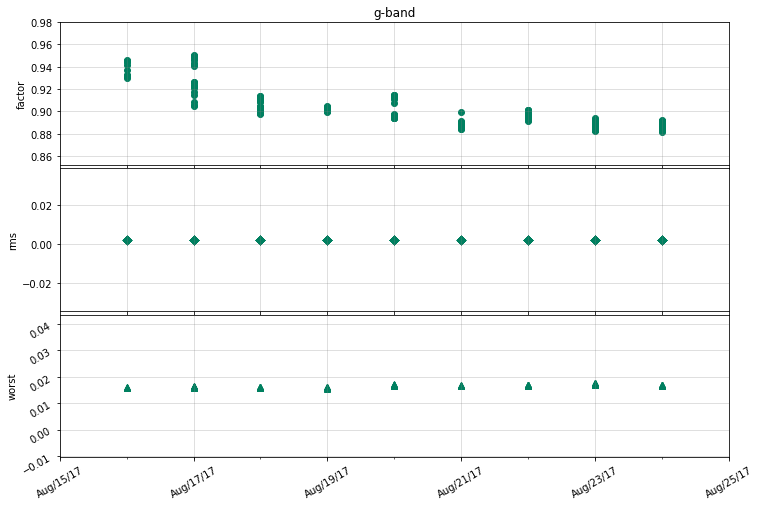

In [21]:
plot_FLATQA(s_g, 'g')

### Band: r

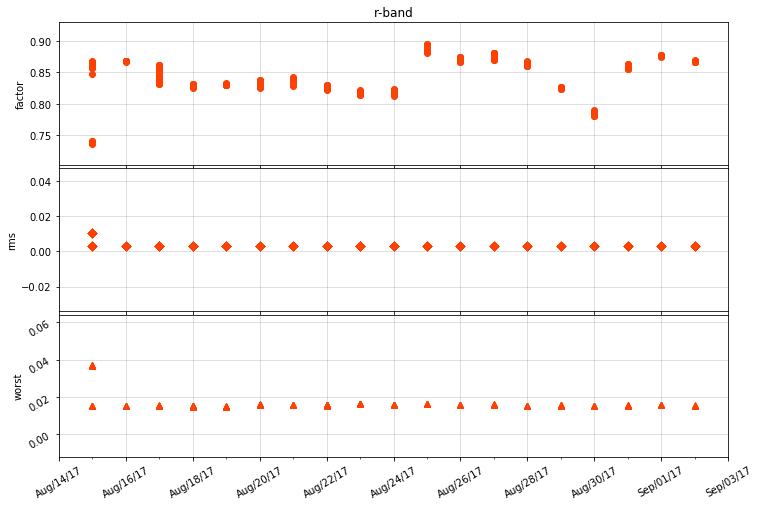

In [28]:
plot_FLATQA(df1, 'r')

#### Selection

In [37]:
# Select those having a factor > 0.75 and keep that EXPNUM list to check against DWT
s_r = df1.copy(deep=True)
s_r = s_r.loc[(s_r['BAND'] == 'r') & (s_r['NITE'].astype('int64') <= 20170824)]
print(len(s_r.index))
s_r = s_r.loc[(s_r['FACTOR'] >= 0.80) & (s_r['WORST'] <= 0.02) & (s_r['RMS'] < 0.01)]
print(len(s_r.index))
# Double checking uniqueness
print(np.unique(s_r['EXPNUM'].values).size)

188
167
167


In [38]:
# Some quick metrics
aux_var_r = (s_r['FACTOR'].max() - s_r['FACTOR'].min()) * 100. / np.median(s_r['FACTOR'])
print('Variability in percetage of the median = {0:.2f}%\nMedian={1:.2f}'.format(aux_var_r, np.median(s_r['FACTOR'])))

Variability in percetage of the median = 6.63%
Median=0.83


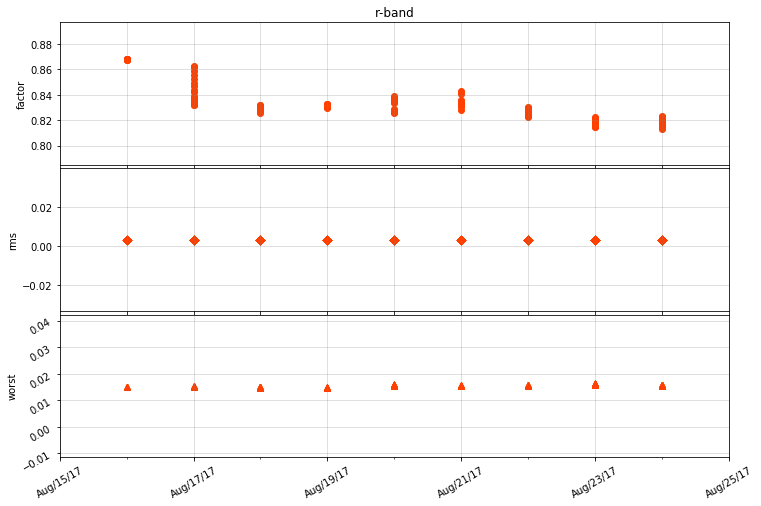

In [39]:
plot_FLATQA(s_r, 'r')

### Band: i

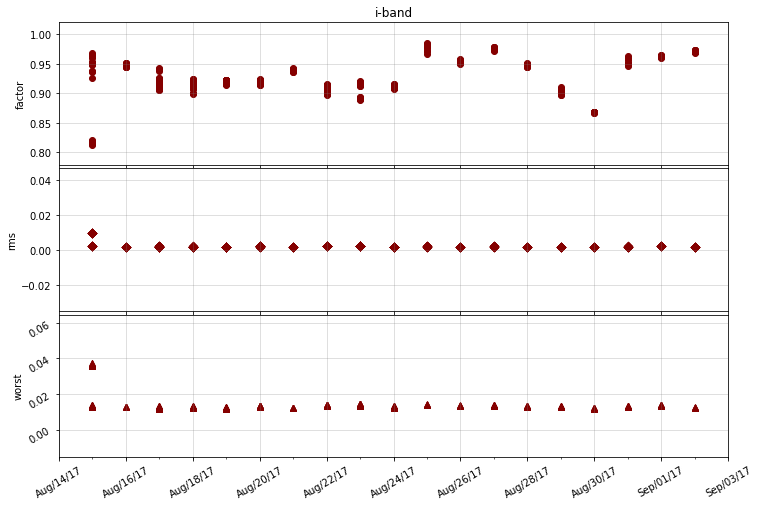

In [40]:
plot_FLATQA(df1, 'i')

#### Selection

In [45]:
# Select those having a factor > 0.75 and keep that EXPNUM list to check against DWT
s_i = df1.copy(deep=True)
s_i = s_i.loc[(s_i['BAND'] == 'i') & (s_i['NITE'].astype('int64') <= 20170824)]
print(len(s_i.index))
s_i = s_i.loc[(s_i['FACTOR'] >= 0.85) & (s_i['WORST'] <= 0.02) & (s_i['RMS'] < 0.009)]
print(len(s_i.index))
# Double checking uniqueness
print(np.unique(s_i['EXPNUM'].values).size)

188
172
172


In [46]:
# Some quick metrics
aux_var_i = (s_i['FACTOR'].max() - s_i['FACTOR'].min()) * 100. / np.median(s_i['FACTOR'])
print('Variability in percetage of the median = {0:.2f}%\nMedian={1:.2f}'.format(aux_var_i, np.median(s_i['FACTOR'])))

Variability in percetage of the median = 7.02%
Median=0.92


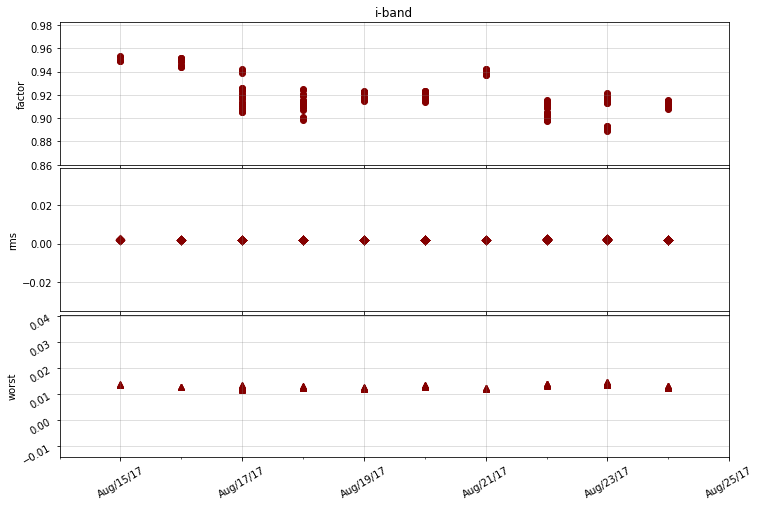

In [47]:
plot_FLATQA(s_i, 'i')

### Band: z

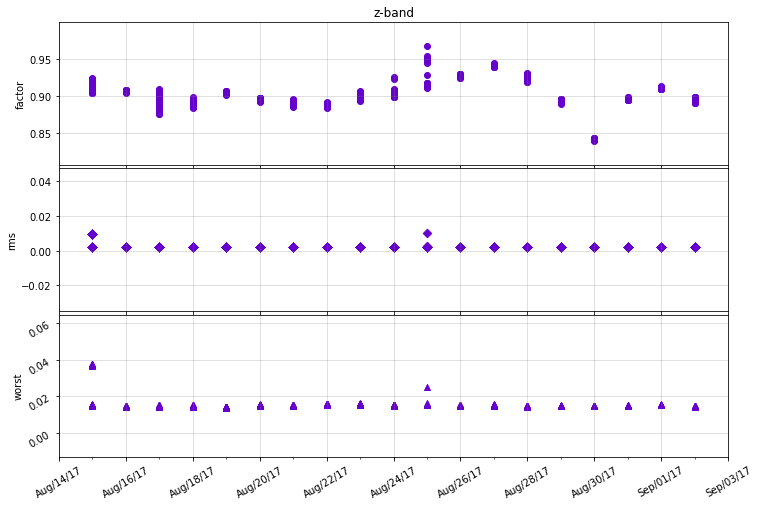

In [48]:
plot_FLATQA(df1, 'z')

#### Selection

In [124]:
# Select those having a factor > 0.75 and keep that EXPNUM list to check against DWT
s_z = df1.copy(deep=True)
s_z = s_z.loc[(s_z['BAND'] == 'z') & (s_z['NITE'].astype('int64') <= 20170824)]
print(len(s_z.index))
s_z = s_z.loc[(s_z['FACTOR'] >= 0.88) & (s_z['WORST'] <= 0.02) & (s_z['RMS'] < 0.009)]  
print(len(s_z.index))
# Double checking uniqueness
print(np.unique(s_z['EXPNUM'].values).size)

368
342
342


In [125]:
# Reduce to half the sample
print(s_z.loc[s_z['NITE'] == '20170821'].info())

s_z.reset_index(drop=True, inplace=True)
idx_half = list(s_z.index)[::2]
s_z = s_z.iloc[idx_half]
print(len(s_z.index))

print(s_z.loc[s_z['NITE'] == '20170821'].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 843 to 862
Data columns (total 9 columns):
NITE        20 non-null object
EXPNUM      20 non-null int64
BAND        20 non-null object
EXPTIME     20 non-null float64
FACTOR      20 non-null float64
RMS         20 non-null float64
WORST       20 non-null float64
ID          20 non-null int64
FILENAME    20 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 1.6+ KB
None
171
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 200 to 218
Data columns (total 9 columns):
NITE        10 non-null object
EXPNUM      10 non-null int64
BAND        10 non-null object
EXPTIME     10 non-null float64
FACTOR      10 non-null float64
RMS         10 non-null float64
WORST       10 non-null float64
ID          10 non-null int64
FILENAME    10 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 800.0+ bytes
None


In [126]:
# Some quick metrics
aux_var_z = (s_z['FACTOR'].max() - s_z['FACTOR'].min()) * 100. / np.median(s_z['FACTOR'])
print('Variability in percetage of the median = {0:.2f}%\nMedian={1:.2f}'.format(aux_var_z, np.median(s_z['FACTOR'])))

Variability in percetage of the median = 4.79%
Median=0.90


['20170815' '20170816' '20170817' '20170818' '20170819' '20170820'
 '20170821' '20170822' '20170823' '20170824']


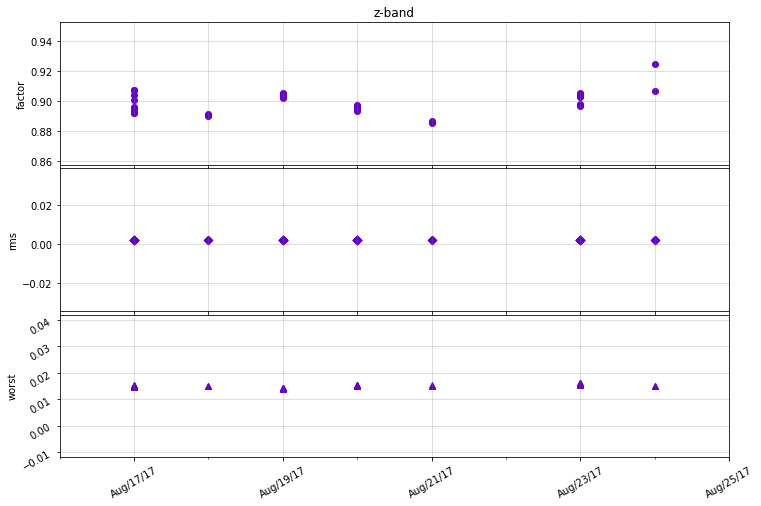

In [127]:
plot_FLATQA(s_z, 'z')
print(s_z['NITE'].unique())

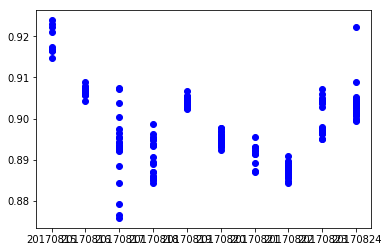

In [119]:
plt.plot(s_z['NITE'], s_z['FACTOR'], 'bo')

### Band: Y

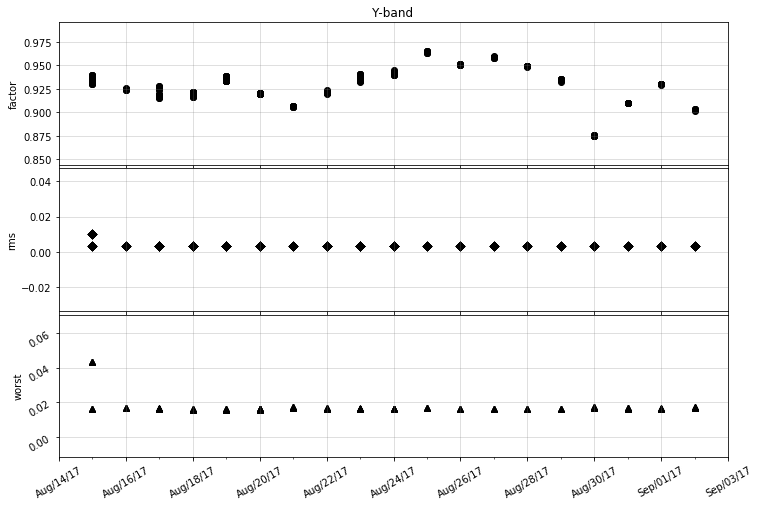

In [128]:
plot_FLATQA(df1, 'Y')

#### Selection

In [131]:
# Select those having a factor > 0.75 and keep that EXPNUM list to check against DWT
s_Y = df1.copy(deep=True)
s_Y = s_Y.loc[(s_Y['BAND'] == 'Y') & (s_Y['NITE'].astype('int64') <= 20170824)]
print(len(s_Y.index))
s_Y = s_Y.loc[(s_Y['WORST'] <= 0.02) & (s_Y['RMS'] < 0.01)] # (s_Y['FACTOR'] >= 0.85) &
print(len(s_Y.index))
# Double checking uniqueness
print(np.unique(s_Y['EXPNUM'].values).size)

188
177
177


In [132]:
# Some quick metrics
aux_var_Y = (s_Y['FACTOR'].max() - s_Y['FACTOR'].min()) * 100. / np.median(s_Y['FACTOR'])
print('Variability in percetage of the median = {0:.2f}%\nMedian={1:.2f}'.format(aux_var_Y, np.median(s_Y['FACTOR'])))

Variability in percetage of the median = 4.21%
Median=0.92


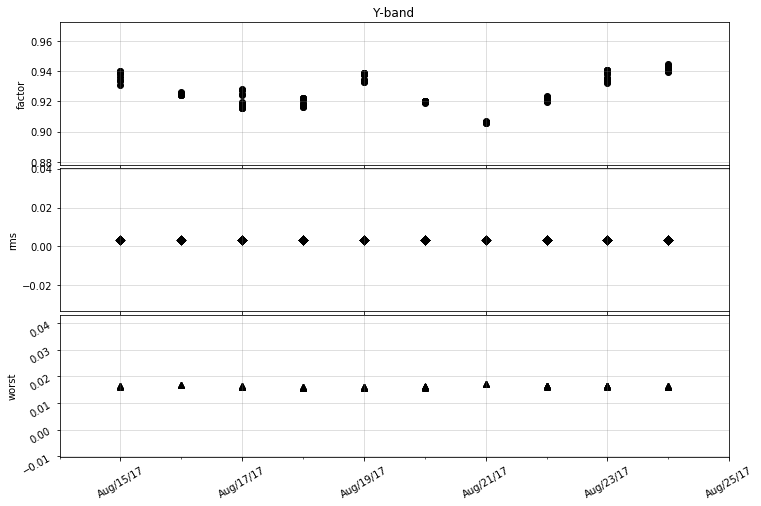

In [133]:
plot_FLATQA(s_Y, 'Y')

### Only considering FLAT_QA based selection, the list of exposures to be used is

In [140]:
expnum_list_v01 = np.r_[s_u['EXPNUM'].values, 
                   s_g['EXPNUM'].values, 
                   s_r['EXPNUM'].values, 
                   s_i['EXPNUM'].values, 
                   s_z['EXPNUM'].values, 
                   s_Y['EXPNUM'].values]
np.savetxt('explist_v01_ugrizY.txt', expnum_list_v01, fmt='%d', delimiter=' ', newline='\n')

### From DWT statistics

### Load Statistics

In [148]:
stt_u = pd.read_csv('qa_u_y5.csv')
stt_g = pd.read_csv('qa_g_y5.csv')
stt_r = pd.read_csv('qa_r_y5.csv')
stt_i = pd.read_csv('qa_i_y5.csv')
stt_z = pd.read_csv('qa_z_y5.csv')
stt_Y = pd.read_csv('qa_Y_y5.csv')

### Crossmatch exposure list selected before with the loaded tables

In [154]:
f_xmatch = lambda x: x[x['db.expnum'].isin(expnum_list_v01)]

In [155]:
stt_u = f_xmatch(stt_u)
stt_g = f_xmatch(stt_g)
stt_r = f_xmatch(stt_r)
stt_i = f_xmatch(stt_i)
stt_z = f_xmatch(stt_z)
stt_Y = f_xmatch(stt_Y)

#### As there are few nights, label them as N1, N2, ...

In [157]:
aux_night = np.sort(stt_r['db.nite'].unique())
aux_n = map(lambda x: 'n{0:02}'.format(x), np.arange(1, len(aux_night) + 1))
Ndict = dict(zip(aux_night, aux_n))
Ndict

{20170816: 'n01',
 20170817: 'n02',
 20170818: 'n03',
 20170819: 'n04',
 20170820: 'n05',
 20170821: 'n06',
 20170822: 'n07',
 20170823: 'n08',
 20170824: 'n09'}

In [158]:
for ni in Ndict.keys():
    stt_u.loc[stt_u['db.nite']==ni, 'db.nite'] = Ndict[ni]
    stt_g.loc[stt_g['db.nite']==ni, 'db.nite'] = Ndict[ni]
    stt_r.loc[stt_r['db.nite']==ni, 'db.nite'] = Ndict[ni]
    stt_i.loc[stt_i['db.nite']==ni, 'db.nite'] = Ndict[ni]
    stt_z.loc[stt_z['db.nite']==ni, 'db.nite'] = Ndict[ni]
    stt_Y.loc[stt_Y['db.nite']==ni, 'db.nite'] = Ndict[ni]

#### Sub sample, only diagonal coeffs

In [159]:
sub_u = stt_u.loc[((stt_u['v.coeff']=='D') & (stt_u['db.band']=='u'))]
sub_g = stt_g.loc[((stt_g['v.coeff']=='D') & (stt_g['db.band']=='g'))]
sub_r = stt_r.loc[((stt_r['v.coeff']=='D') & (stt_r['db.band']=='r'))]
sub_i = stt_i.loc[((stt_i['v.coeff']=='D') & (stt_i['db.band']=='i'))]
sub_z = stt_z.loc[((stt_z['v.coeff']=='D') & (stt_z['db.band']=='z'))]
sub_Y = stt_Y.loc[((stt_Y['v.coeff']=='D') & (stt_Y['db.band']=='Y'))]

#### Common set for the plots

In [160]:
band = ['u', 'g', 'r', 'i', 'z', 'Y']
param_list = ['v.mean', 'v.rms', 'v.rms_all', 'v.mad', 'v.nclust', 'v.npeak']

In [161]:
def plot_dwt(tmp_df):
    plt.close('all')
    fig, ax = plt.subplots(3, 2, figsize=(18, 10))
    slicer = 0
    for d0 in range(3):
        for d1 in range(2):
            dfaux =  tmp_df.loc[tmp_df['v.level']==1]
            ax[d0, d1].scatter(dfaux['db.nite'], dfaux[param_list[slicer]], c=BAND_COLORS[band[0]], marker='D', 
                               label=param_list[slicer] + ' l=1')
            ####
            dfaux =  tmp_df.loc[tmp_df['v.level']==2]
            ax[d0, d1].scatter(dfaux['db.nite'], dfaux[param_list[slicer]], c='magenta', marker='*',
                               label=param_list[slicer] + ' l=2')
            ax[d0, d1].legend()
            slicer += 1
            #
            ax[d0, d1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            plt.subplots_adjust(hspace=0.025)
            if (d0 < 2):
                plt.setp(ax[d0, d1].get_xticklabels(), visible=False)
            else:
                ax[d0, d1].tick_params(rotation=30)

### Band: u

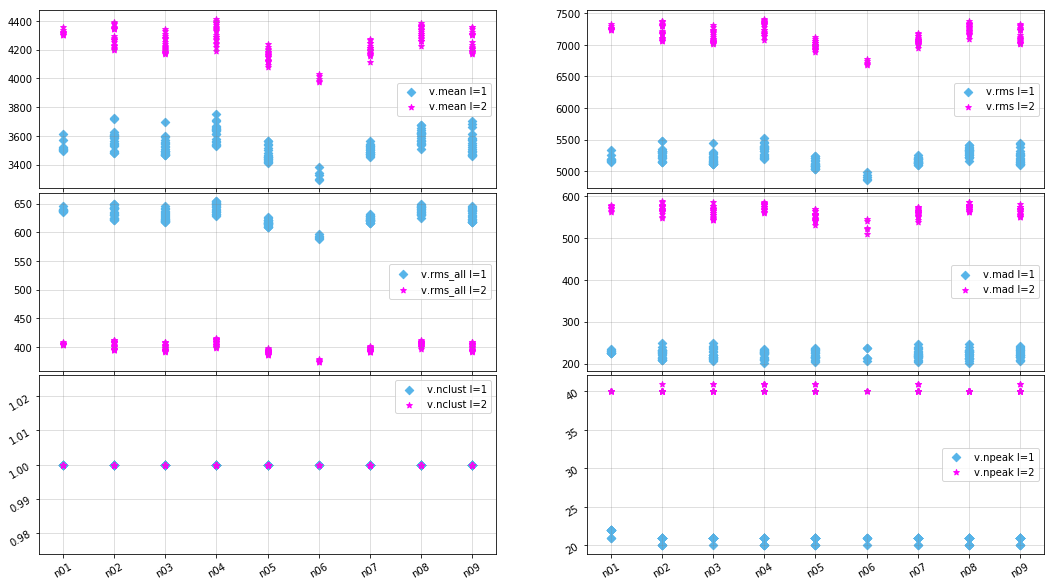

In [162]:
plot_dwt(sub_u)

### Band: g

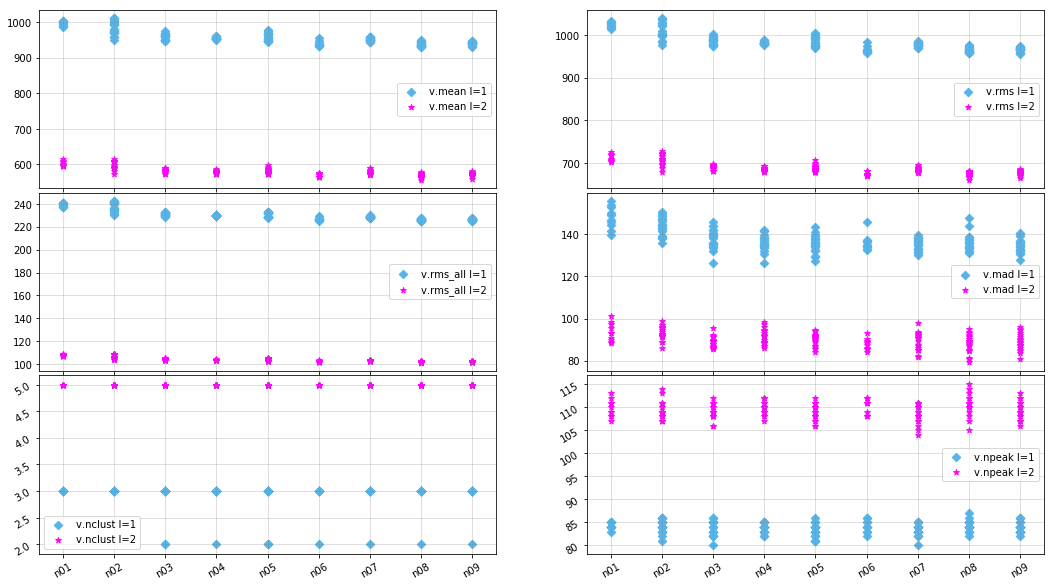

In [163]:
plot_dwt(sub_g)

### Band: r

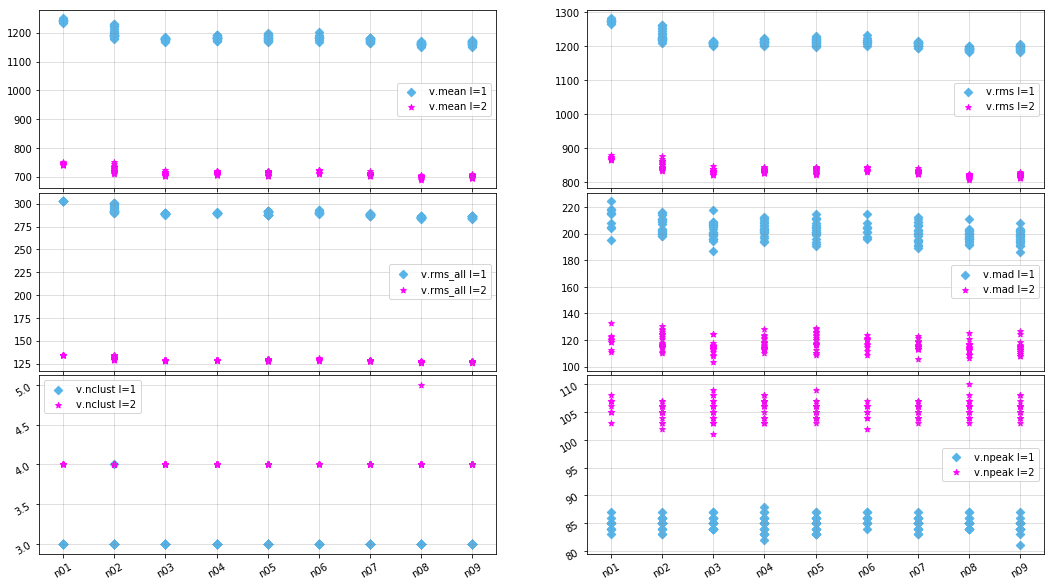

In [164]:
plot_dwt(sub_r)

### Band: i

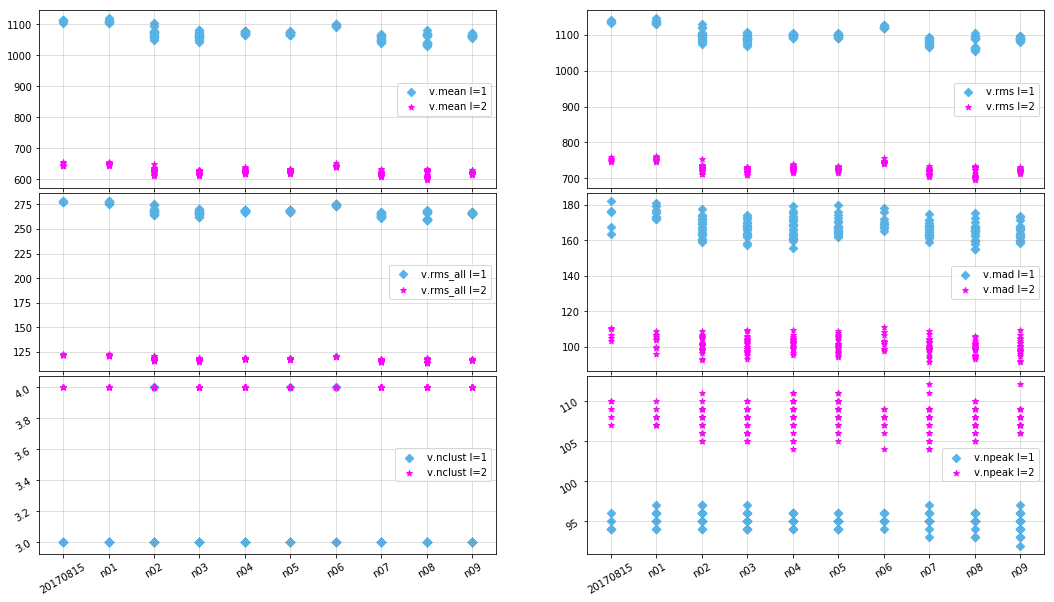

In [165]:
plot_dwt(sub_i)

### Band: z

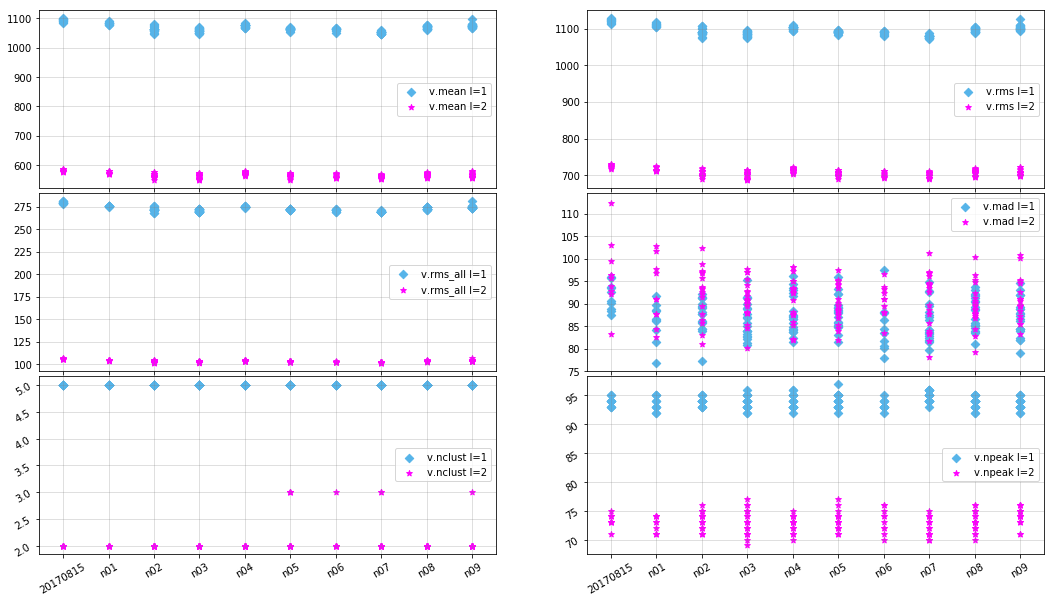

In [166]:
plot_dwt(sub_z)

### Band: Y

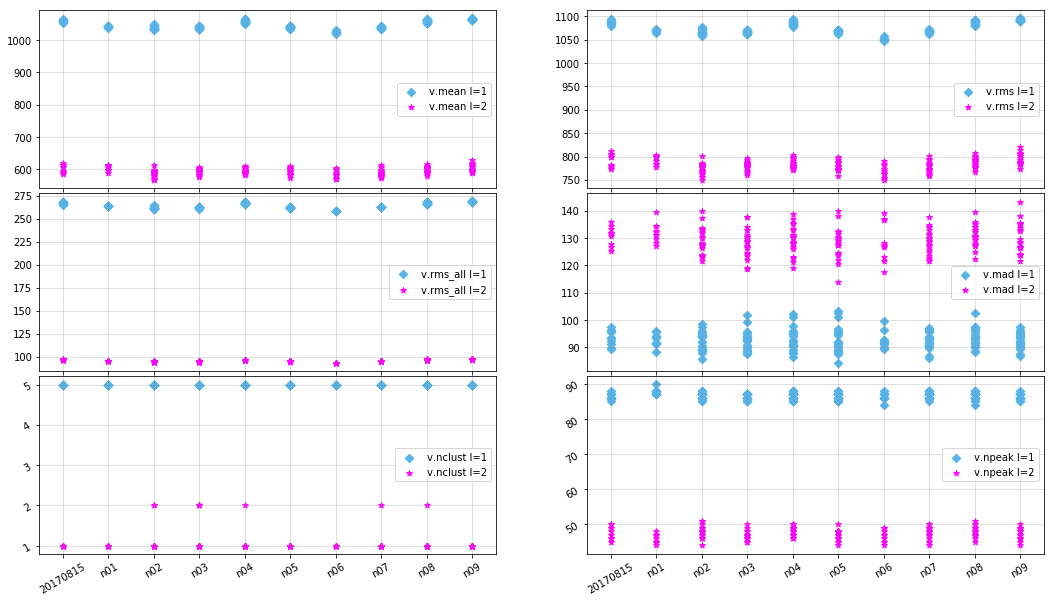

In [167]:
plot_dwt(sub_Y)

# **Scratch area**
 ==========================

#### Need to additionally remove z-band exposures from 20170815 (30 of 40), 20170930 (10 of 20),  20171122 (10 of 20), 20180113 (10 of 20). 
#### Also, 10 Y band from 20170815

In [ ]:
Ndict

In [ ]:
z1 = sub_z.loc[sub_z['db.nite'] == 'n1', 'db.expnum'].values[::3]
z2 = sub_z.loc[sub_z['db.nite'] == 'n2', 'db.expnum'].values[::2]
z3 = sub_z.loc[sub_z['db.nite'] == 'n3', 'db.expnum'].values[::2]
z4 = sub_z.loc[sub_z['db.nite'] == 'n4', 'db.expnum'].values[::2]
exclude_add_z = np.r_[z1, z2, z3, z4]

In [ ]:
Y1 = sub_Y.loc[sub_Y['db.nite'] == 'n1', 'db.expnum'].values[::2]

In [ ]:
### Write out the list of excluded
exclude_ugri = np.r_[exclude_u, exclude_g, exclude_r, exclude_i, exclude_add_z, Y1]
exclude_ugri.shape
np.savetxt('exclude_y5_OnePerEpoch.csv', exclude_ugri, fmt='%d')

### Need to generate 'include' lists (bias and flats) to generate domeflats Y-band for 20170815, and z-band for 20170930, 20171122, 20180113
#### They were not generated when the argument '--max_num 10' was used in submit_nitelycal
#### Here I will create by hand the lists, based on info from EXPOSURE table

In [ ]:
Y20170815_zero = np.r_[np.arange(667321, 667330 + 1), np.arange(667333, 667343 + 1)]
Y20170815_dflat = np.r_[np.arange(667412, 667421 + 1)]
Y20170815 = np.r_[Y20170815_zero, Y20170815_dflat]
Y20170815.shape
Y20170815_zero

In [ ]:
z20170930_zero = np.arange(683179, 683188 + 1)
z20170930_dflat = np.arange(683236, 683245 + 1)
z20170930 = np.r_[z20170930_zero, z20170930_dflat]
z20170930.shape

In [ ]:
z20171122_zero = np.arange(698605, 698614 + 1)
z20171122_dflat = np.arange(698662, 698671 + 1)
z20171122 = np.r_[z20171122_zero, z20171122_dflat]
z20171122.shape

In [ ]:
z20180113_zero = np.arange(711808, 711817 + 1) 
z20180113_dflat = np.arange(711865, 711874 + 1)
z20180113 = np.r_[z20180113_zero, z20180113_dflat]
z20180113.shape

In [ ]:
Yz_newRun_include = np.r_[Y20170815, z20170930, z20171122, z20180113]

#### Write out the include list to run the missing 

In [ ]:
np.savetxt('include_missingYz_y5_OnePerEpoch.csv', Yz_newRun_include, fmt='%d')

In [ ]:
np.savetxt('include_missing_Y20170815_y5_OnePerEpoch.csv', Y20170815, fmt='%d')
np.savetxt('include_missing_z20170930_y5_OnePerEpoch.csv', z20170930, fmt='%d')
np.savetxt('include_missing_z20171122_y5_OnePerEpoch.csv', z20171122, fmt='%d')
np.savetxt('include_missing_z20180113_y5_OnePerEpoch.csv', z20180113, fmt='%d')

#### Following there are the bias_list and flat_list that we're really going to use, with '--biaslist' and '--flatlist' arguments

In [ ]:
np.savetxt('bias_missing_Y20170815_y5_OnePerEpoch.csv', Y20170815_zero, fmt='%d')
np.savetxt('bias_missing_z20170930_y5_OnePerEpoch.csv', z20170930_zero, fmt='%d')
np.savetxt('bias_missing_z20171122_y5_OnePerEpoch.csv', z20171122_zero, fmt='%d')
np.savetxt('bias_missing_z20180113_y5_OnePerEpoch.csv', z20180113_zero, fmt='%d')

np.savetxt('flat_missing_Y20170815_y5_OnePerEpoch.csv', Y20170815_dflat, fmt='%d')
np.savetxt('flat_missing_z20170930_y5_OnePerEpoch.csv', z20170930_dflat, fmt='%d')
np.savetxt('flat_missing_z20171122_y5_OnePerEpoch.csv', z20171122_dflat, fmt='%d')
np.savetxt('flat_missing_z20180113_y5_OnePerEpoch.csv', z20180113_dflat, fmt='%d')